# Anomaly Detection with Autoencoders

In [ ]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa

### Extract an MFCC for each cough audio file in the dataset and store it in a Panda Dataframe along with it's class label 

In [7]:
def extract_mfccs(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsnorm = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("file could not be loaded: ", file)
        return None 
     
    return mfccsnorm

In [ ]:
# Set the path to the cough dataset 
fulldatasetpath = 'C:\\Users\\Documents\\Cough Detection\\Data\\cough\\'

metadata = pd.read_csv('C:\\Users\\Documents\\Cough Detection\\Data\\cough.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),str(row["file_name"]))
    
    class_label = row["class_name"]
    data = extract_mfccs(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdataframe = pd.DataFrame(features, columns=['feature','class_label'])

print('features extracted from ', len(featuresdataframe), ' files') 

In [10]:
print(featuresdataframe)

                                               feature class_label
0    [-200.70184, 99.20585, -72.28148, 21.80312, -9...       cough
1    [-314.28616, 90.3109, -68.50514, 15.40077, -12...       cough
2    [-314.4416, 93.78775, -13.789625, 2.641592, -5...       cough
3    [-310.52585, 71.25459, -68.1882, -6.732506, 1....       cough
4    [-256.3385, 131.29033, -78.243164, 8.587592, 1...       cough
..                                                 ...         ...
995  [-250.20494, 186.81802, -40.3024, -2.6410193, ...       cough
996  [-277.06705, 167.86713, -2.8843956, 1.5124706,...       cough
997  [-296.343, 167.84077, -85.02909, 25.053547, -3...       cough
998  [-196.3671, 159.38153, -61.271618, 39.612797, ...       cough
999  [-430.52194, 184.45177, -46.895187, -42.32516,...       cough

[1000 rows x 2 columns]


### Convert the categorical text data into model-understandable numerical data. 

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and Class labels into numpy arrays
X = np.array(featuresdataframe.feature.tolist())
y = np.array(featuresdataframe.class_label.tolist())

# Encode the classification labels
labelen = LabelEncoder()
classen = to_categorical(labelen.fit_transform(y)) 

Using TensorFlow backend.


### Split the dataset into training and testing sets. The testing set size will be 10% and we will set a random state. 


In [12]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, classen, test_size=0.1, random_state = 42)

In [13]:
print(f"train count: {len(x_train)}")

train count: 900


In [14]:
input_dim = x_train.shape[1]
print(input_dim)

40


In [15]:
print(X.shape[1])

40


### Create the Autoencoder Model with L1 Sparsity Penalty as 1e-5 and Loss function as MSE

In [181]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import l1

model = Sequential()
model.add(Dense(512, input_dim=X.shape[1], activity_regularizer=l1(0.00001), activation='relu'))
model.add(Dense(224, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(X.shape[1])) # Multiple output neurons

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 512)               20992     
_________________________________________________________________
dense_55 (Dense)             (None, 224)               114912    
_________________________________________________________________
dense_56 (Dense)             (None, 512)               115200    
_________________________________________________________________
dense_57 (Dense)             (None, 40)                20520     
Total params: 271,624
Trainable params: 271,624
Non-trainable params: 0
_________________________________________________________________


In [182]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [183]:
history=model.fit(x_train,x_train,verbose=1,epochs=90)

Train on 900 samples
Epoch 1/90
900/900 [==============================] - 0s 435us/sample - loss: 875.7804 - accuracy: 0.9244
Epoch 2/90
900/900 [==============================] - 0s 66us/sample - loss: 81.3038 - accuracy: 0.9967
Epoch 3/90
900/900 [==============================] - 0s 69us/sample - loss: 46.5264 - accuracy: 0.9900
Epoch 4/90
900/900 [==============================] - 0s 70us/sample - loss: 31.9904 - accuracy: 0.9878
Epoch 5/90
900/900 [==============================] - 0s 71us/sample - loss: 23.7607 - accuracy: 0.9911
Epoch 6/90
900/900 [==============================] - 0s 70us/sample - loss: 18.5942 - accuracy: 0.9889
Epoch 7/90
900/900 [==============================] - 0s 68us/sample - loss: 14.1450 - accuracy: 0.9889
Epoch 8/90
900/900 [==============================] - 0s 72us/sample - loss: 11.2297 - accuracy: 0.9878
Epoch 9/90
900/900 [==============================] - 0s 71us/sample - loss: 9.1948 - accuracy: 0.9911
Epoch 10/90
900/900 [=====================

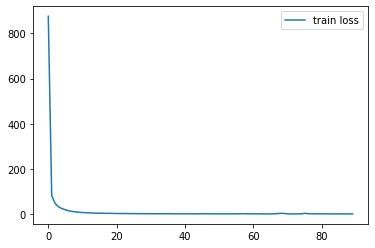

In [184]:
plt.plot(history.history['loss'], label='train loss')
#plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

### Calculate the MSE for the Test Dataset (out of sample) and on the Whole Dataset (In + Out Sample)

In [185]:
pred = model.predict(x_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_test))
pred = model.predict(X)
score2 = np.sqrt(metrics.mean_squared_error(pred,X))

print(f"Out of Sample Score (RMSE): {score1}")
print(f"Insample Normal Score (RMSE): {score2}")


Out of Sample Score (RMSE): 0.6133102178573608
Insample Normal Score (RMSE): 0.5205418467521667


### Use the model to predict the MSE for validation set 

In [236]:
filename = 'C:\\Users\\\\Documents\\Audio Classification\\Evaluation audio\\siren_1.wav' 


In [237]:
def extract_mfccs(filename):
   
    try:
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsnorm = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("file could not be loaded: ", file)
        return None 
     
    return mfccsnorm

In [238]:
prediction_feature = extract_mfccs(filename)

In [240]:
pred = model.predict(prediction_feature)
score3 = np.sqrt(metrics.mean_squared_error(pred,prediction_feature))
print(f"Validation sample (RMSE): {score3}")

Attack Underway Score (RMSE): 1.4563369750976562


### Save the Model

In [241]:
model.save('C:\\Users\\\\Documents\\Cough Detection\\Data\\autoencoder_model_4.h5')